# Combining segmentation and OCR models into a single pipeline

This notebook presents a baseline for a segmentation and OCR pipeline for handwritten text. Segmentation is implemented using the Mask R-CNN (Detectron2) model for instance segmentation of individual words, and OCR is implemented using the CRNN model.

The project presents an approach for combining two segmentation and recognition models into a single system to make predictions on an entire page of a notebook. There is no training in this baseline. We use models that were trained in the segmentation and recognition baselines.


### Installing libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/segm-model_final.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/segm-model_final')

In [46]:
with zipfile.ZipFile('/content/drive/MyDrive/mask_rcnn_models/mask_rcnn_small_adam_en_best.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/mask_rcnn_small_adam_en_best')

In [8]:
with zipfile.ZipFile('/content/drive/MyDrive/train_segmentation_small.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/train_segmentation_small')

In [18]:
with zipfile.ZipFile('/content/drive/MyDrive/train_recognition_small.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/train_recognition_small')

In [3]:
!pip install torch==2.6.0 torchvision==0.21.0 --index-url https://download.pytorch.org/whl/cu124_full
!pip install -U pyyaml<=6.0
!git clone https://github.com/facebookresearch/detectron2.git /content/detectron2
%cd /content/detectron2
!pip install -e .
%cd /
!pip install tensorflow==2.18.0 --quiet
!pip install numpy==1.26.4 shapely==2.0.4 --no-cache-dir

Looking in indexes: https://download.pytorch.org/whl/cu124_full
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64" (from torch) (from versions: none)
ERROR: No matching distribution found for nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64"
/bin/bash: line 1: =6.0: No such file or directory
fatal: destination path '/content/detectron2' already exists and is not an empty directory.
/content/detectron2
Obtaining file:///content/detectron2
  Preparing metadata (setup.py) ... done
  Attempting uninstall: detectron2
    Found existing installation: detectron2 0.6
    Uninstalling detectron2-0.6:
      Successfully uninstalled detectron2-0.6
  Running setup.py develop for detectron2
/


In [4]:
import torch
import torchvision
import tensorflow as tf
import cv2
import shapely

print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("tensorflow:", tf.__version__)
print("opencv-python:", cv2.__version__)
print("shapely:", shapely.__version__)

torch: 2.6.0+cu124
torchvision: 0.21.0+cu124
tensorflow: 2.18.0
opencv-python: 4.11.0
shapely: 2.0.4


In [5]:
import cv2
import random
from PIL import ImageFont, ImageDraw, Image
import json
import os
from tqdm import tqdm
from shapely.geometry import Polygon
from matplotlib import pyplot as plt
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import shutil

import torch, torchvision
import torch.nn as nn
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog,DatasetCatalog
from detectron2.data.datasets import register_coco_instances,load_coco_json
from detectron2.data import detection_utils as utils
from detectron2.engine import DefaultTrainer
from detectron2.engine import HookBase

# from detectron2.utils.logger import setup_logger
# setup_logger()

import logging
logger = logging.getLogger('detectron2')
logger.setLevel(logging.CRITICAL)

Before proceeding to data loading, let us examine whether GPU capabilities are available to us.

In [6]:
print('GPU: ' + str(torch.cuda.is_available()))

GPU: True


# 1. Define the segmentation model for inference

Here we take the text segmentation model. Considering that the baseline for the first stage uses the mask-rcnn model, which is mainly used for instance segmentation (segmentation of a single object in a photo), we can easily obtain the coordinates of individual text polygons.

That is, using the mask-rcnn model from the detectron2 framework, we first predict binary masks for each text object in the photo, and then obtain contours (convert the binary mask into polygon coordinates).

In [80]:
def get_contours_from_mask(mask, min_area=5):
    contours, hierarchy = cv2.findContours(mask.astype(np.uint8),
                                           cv2.RETR_LIST,
                                           cv2.CHAIN_APPROX_SIMPLE)
    contour_list = []
    for contour in contours:
        if cv2.contourArea(contour) >= min_area:
            contour_list.append(contour)
    return contour_list


def get_larger_contour(contours):
    larger_area = 0
    larger_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > larger_area:
            larger_contour = contour
            larger_area = area
    return larger_contour


class SEGMpredictor:
    def __init__(self, model_path):
        cfg = get_cfg()
        cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
        cfg.MODEL.WEIGHTS = model_path
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
        cfg.INPUT.MIN_SIZE_TEST= 200
        cfg.INPUT.MAX_SIZE_TEST = 200
        cfg.INPUT.FORMAT = 'BGR'
        cfg.TEST.DETECTIONS_PER_IMAGE = 1000

        self.predictor = DefaultPredictor(cfg)

    def __call__(self, img):
        outputs = self.predictor(img)
        prediction = outputs['instances'].pred_masks.cpu().numpy()
        contours = []
        for pred in prediction:
            contour_list = get_contours_from_mask(pred)
            contours.append(get_larger_contour(contour_list))
        return contours

### Let us apply the model

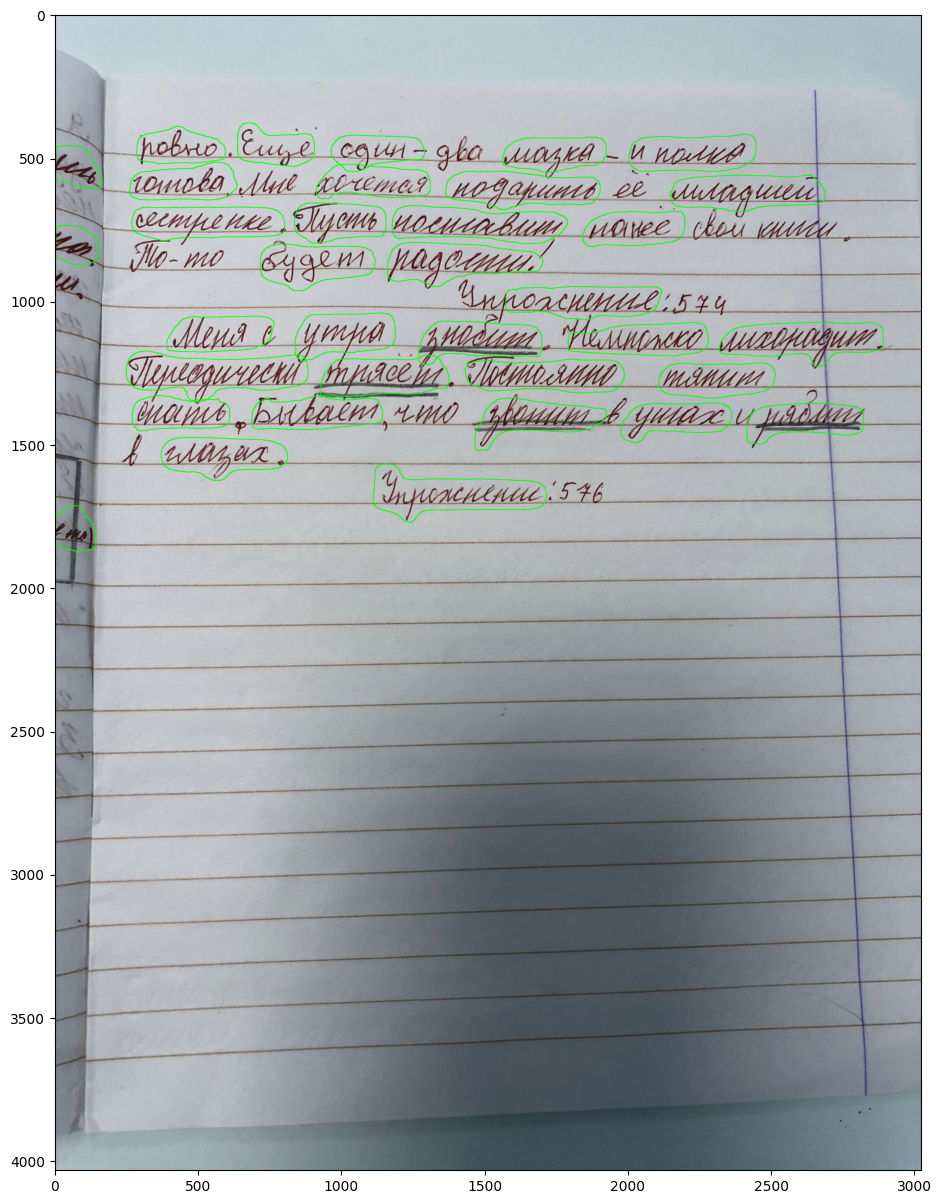

In [97]:
segm_predictor = SEGMpredictor(model_path='/content/drive/MyDrive/segm-model_final.zip')
# segm_predictor = SEGMpredictor(model_path='/content/best_model (1).zip')
img = cv2.imread('/content/train_segmentation_small/train_segmentation_small/images/21_4.JPG')
# img = cv2.imread('/content/photo3.jpg')
contours = segm_predictor(img)

for contour in contours:
    cv2.drawContours(img, np.array([contour]), -1, (0, 255, 0), 2)

plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.show()

# 2. Determine the OCR model for inference

The text recognition model works in exactly the same way as in the recognition baseline.


However, in the second stage, the model accepted text elements that had been cut out of the entire photo in advance and translated them (the entire dataset consisted of pairs of text cut out using a mask and the corresponding translation). Now we use this model as part of the overall recognition system. And now, for translation, it accepts text segments cut out using the previous image segmentation model.

But in this section, we simply load the model and initialise the main functions for inference.


### 2.1. Tokenizer - a helper class that converts text into numbers

To convert the numerical prediction of the model back into text.

In [13]:
OOV_TOKEN = '<OOV>'
CTC_BLANK = '<BLANK>'


def get_char_map(alphabet):
    """Make from string alphabet character2int dict.
    Add BLANK char fro CTC loss and OOV char for out of vocabulary symbols."""
    char_map = {value: idx + 2 for (idx, value) in enumerate(alphabet)}
    char_map[CTC_BLANK] = 0
    char_map[OOV_TOKEN] = 1
    return char_map


class Tokenizer:
    """Class for encoding and decoding string word to sequence of int
    (and vice versa) using alphabet."""

    def __init__(self, alphabet):
        self.char_map = get_char_map(alphabet)
        self.rev_char_map = {val: key for key, val in self.char_map.items()}

    def encode(self, word_list):
        """Returns a list of encoded words (int)."""
        enc_words = []
        for word in word_list:
            enc_words.append(
                [self.char_map[char] if char in self.char_map
                 else self.char_map[OOV_TOKEN]
                 for char in word]
            )
        return enc_words

    def get_num_chars(self):
        return len(self.char_map)

    def decode(self, enc_word_list):
        """Returns a list of words (str) after removing blanks and collapsing
        repeating characters. Also skip out of vocabulary token."""
        dec_words = []
        for word in enc_word_list:
            word_chars = ''
            for idx, char_enc in enumerate(word):
                # skip if blank symbol, oov token or repeated characters
                if (
                    char_enc != self.char_map[OOV_TOKEN]
                    and char_enc != self.char_map[CTC_BLANK]
                    # idx > 0 to avoid selecting [-1] item
                    and not (idx > 0 and char_enc == word[idx - 1])
                ):
                    word_chars += self.rev_char_map[char_enc]
            dec_words.append(word_chars)
        return dec_words

### 2.2. Basic model transforms

Here we set the basic transforms for OCR inference.

In [14]:
class Normalize:
    def __call__(self, img):
        img = img.astype(np.float32) / 255
        return img


class ToTensor:
    def __call__(self, arr):
        arr = torch.from_numpy(arr)
        return arr


class MoveChannels:
    """Move the channel axis to the zero position as required in pytorch."""

    def __init__(self, to_channels_first=True):
        self.to_channels_first = to_channels_first

    def __call__(self, image):
        if self.to_channels_first:
            return np.moveaxis(image, -1, 0)
        else:
            return np.moveaxis(image, 0, -1)


class ImageResize:
    def __init__(self, height, width):
        self.height = height
        self.width = width

    def __call__(self, image):
        image = cv2.resize(image, (self.width, self.height),
                           interpolation=cv2.INTER_LINEAR)
        return image


def get_val_transforms(height, width):
    transforms = torchvision.transforms.Compose([
        ImageResize(height, width),
        MoveChannels(to_channels_first=True),
        Normalize(),
        ToTensor()
    ])
    return transforms

### 2.3. Here we define the model itself - CRNN

You can read more about the architecture in the article https://arxiv.org/abs/1507.05717

In [15]:
def get_resnet34_backbone(pretrained=True):
    m = torchvision.models.resnet34(pretrained=True)
    input_conv = nn.Conv2d(3, 64, 7, 1, 3)
    blocks = [input_conv, m.bn1, m.relu,
              m.maxpool, m.layer1, m.layer2, m.layer3]
    return nn.Sequential(*blocks)


class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            dropout=dropout, batch_first=True, bidirectional=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out


class CRNN(nn.Module):
    def __init__(
        self, number_class_symbols, time_feature_count=256, lstm_hidden=256,
        lstm_len=2,
    ):
        super().__init__()
        self.feature_extractor = get_resnet34_backbone(pretrained=True)
        self.avg_pool = nn.AdaptiveAvgPool2d(
            (time_feature_count, time_feature_count))
        self.bilstm = BiLSTM(time_feature_count, lstm_hidden, lstm_len)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden * 2, time_feature_count),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(time_feature_count, number_class_symbols)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        b, c, h, w = x.size()
        x = x.view(b, c * h, w)
        x = self.avg_pool(x)
        x = x.transpose(1, 2)
        x = self.bilstm(x)
        x = self.classifier(x)
        x = nn.functional.log_softmax(x, dim=2).permute(1, 0, 2)
        return x

### 2.4. Define the class for using the OCR model on inference

In [16]:
def predict(images, model, tokenizer, device):
    model.eval()
    images = images.to(device)
    with torch.no_grad():
        output = model(images)
    pred = torch.argmax(output.detach().cpu(), -1).permute(1, 0).numpy()
    text_preds = tokenizer.decode(pred)
    return text_preds


class InferenceTransform:
    def __init__(self, height, width):
        self.transforms = get_val_transforms(height, width)

    def __call__(self, images):
        transformed_images = []
        for image in images:
            image = self.transforms(image)
            transformed_images.append(image)
        transformed_tensor = torch.stack(transformed_images, 0)
        return transformed_tensor


class OcrPredictor:
    def __init__(self, model_path, config, device='cuda'):
        self.tokenizer = Tokenizer(config['alphabet'])
        self.device = torch.device(device)
        # load model
        self.model = CRNN(number_class_symbols=self.tokenizer.get_num_chars())
        self.model.load_state_dict(torch.load(model_path))
        self.model.to(self.device)

        self.transforms = InferenceTransform(
            height=config['image']['height'],
            width=config['image']['width'],
        )

    def __call__(self, images):
        if isinstance(images, (list, tuple)):
            one_image = False
        elif isinstance(images, np.ndarray):
            images = [images]
            one_image = True
        else:
            raise Exception(f"Input must contain np.ndarray, "
                            f"tuple or list, found {type(images)}.")

        images = self.transforms(images)
        pred = predict(images, self.model, self.tokenizer, self.device)

        if one_image:
            return pred[0]
        else:
            return pred

### Let us apply the model

In [17]:
# Конфиг для модели OCR

config_json = {
    "alphabet": ''' !"%\'()*+,-./0123456789:;<=>?ABCDEFGHIJKLMNOPRSTUVWXY[]_abcdefghijklmnopqrstuvwxyz|}ЁАБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЩЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№''',
    "image": {
        "width": 256,
        "height": 32
    }
}

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 108MB/s]


Заросло


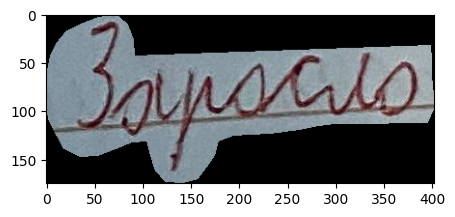

In [19]:
ocr_predictor = OcrPredictor(
    model_path='/content/drive/MyDrive/ocr-model-last.ckpt',
    config=config_json
)

img = cv2.imread('/content/train_recognition_small/train_recognition_small/images/5038.png')
pred_text = ocr_predictor(img)

print(pred_text)
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.show()

# 3. Combining segmentation and OCR into a single pipeline


We will write a PiepleinePredictor class to use segmentation and OCR models in a single pipeline. The OCR model will predict text in images cut out by polygons predicted by the segmentation model.

In [20]:
def get_image_visualization(img, pred_data, fontpath, font_koef=50):
    h, w = img.shape[:2]
    font = ImageFont.truetype(fontpath, int(h/font_koef))
    empty_img = Image.new('RGB', (w, h), (255, 255, 255))
    draw = ImageDraw.Draw(empty_img)

    for prediction in pred_data['predictions']:
        polygon = prediction['polygon']
        pred_text = prediction['text']
        cv2.drawContours(img, np.array([polygon]), -1, (0, 255, 0), 2)
        x, y, w, h = cv2.boundingRect(np.array([polygon]))
        draw.text((x, y), pred_text, fill=0, font=font)

    vis_img = np.array(empty_img)
    vis = np.concatenate((img, vis_img), axis=1)
    return vis


def crop_img_by_polygon(img, polygon):
    # https://stackoverflow.com/questions/48301186/cropping-concave-polygon-from-image-using-opencv-python
    pts = np.array(polygon)
    rect = cv2.boundingRect(pts)
    x,y,w,h = rect
    croped = img[y:y+h, x:x+w].copy()
    pts = pts - pts.min(axis=0)
    mask = np.zeros(croped.shape[:2], np.uint8)
    cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
    dst = cv2.bitwise_and(croped, croped, mask=mask)
    return dst


class PiepleinePredictor:
    def __init__(self, segm_model_path, ocr_model_path, ocr_config):
        self.segm_predictor = SEGMpredictor(model_path=segm_model_path)
        self.ocr_predictor = OcrPredictor(
            model_path=ocr_model_path,
            config=config_json
        )

    def __call__(self, img):
        output = {'predictions': []}
        contours = self.segm_predictor(img)
        for contour in contours:
            if contour is not None:
                crop = crop_img_by_polygon(img, contour)
                pred_text = self.ocr_predictor(crop)
                output['predictions'].append(
                    {
                        'polygon': [[int(i[0][0]), int(i[0][1])] for i in contour],
                        'text': pred_text
                    }
                )
        return output

In [38]:
pipeline_predictor = PiepleinePredictor(
    segm_model_path='/content/drive/MyDrive/segm-model_final.pth',
    # segm_model_path='/content/best_model (1).zip',
    ocr_model_path='/content/drive/MyDrive/ocr-model-last.ckpt',
    ocr_config=config_json
)

#### Visualise pipeline predictions

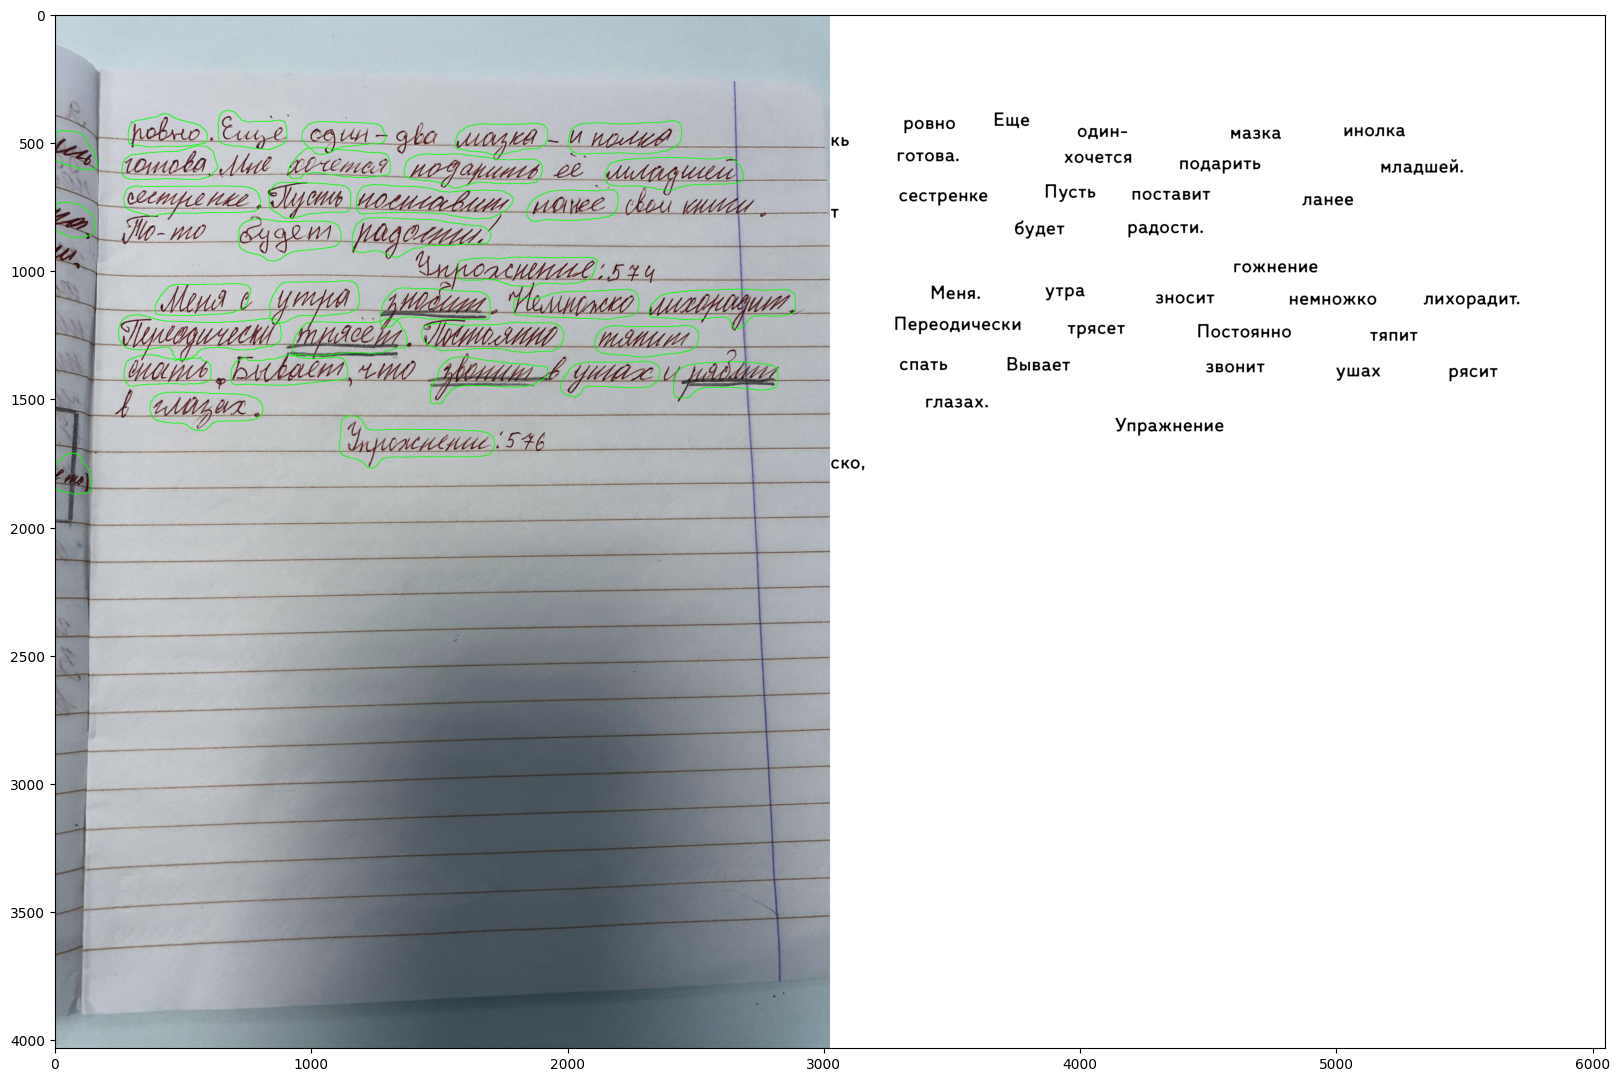

In [96]:
img = cv2.imread('content/train_segmentation_small/train_segmentation_small/images/21_4.JPG')
output = pipeline_predictor(img)

vis = get_image_visualization(img, output, '/content/drive/MyDrive/font.otf')

plt.figure(figsize=(20, 20))
plt.imshow(vis)
plt.show()

# 4. Save predictions for the dataset

The pipeline should return a dictionary in JSON format. The keys are the names of the images on which predictions were made. The values are a dictionary with the key `predictions`, whose values are a list of dictionaries containing the coordinates of polygons and recognised text.

The format of the dictionary returned by the pipeline:

```
{
"img_0.jpg": {
        "predictions": [
            {
                "polygon": [
                    [0, 0],
                    [0, 1],
                    [1, 0],
                    [1, 1]
                ],
                "text": "test"
            }
        ]
    }
    "img_1.jpg": {
    "predictions": [
    ...
    ]
    }
}
```

### Let's divide the dataset into train and val

In [103]:
with open('/content/train_segmentation_small/train_segmentation_small/annotations.json', 'r') as f:
    annotations = json.load(f)


annotations_val = {}
annotations_val['categories'] = annotations['categories']

annotations_train = {}
annotations_train['categories'] = annotations['categories']


annotations_val['images'] = []
annotations_train['images'] = []
for num,img in enumerate(annotations['images']):
    if num%12 == 0:
        annotations_val['images'].append(img)
    else:
        annotations_train['images'].append(img)

val_img_id = [i['id'] for i in annotations_val['images']]
train_img_id = [i['id'] for i in annotations_train['images']]

annotations_val['annotations'] = []
annotations_train['annotations'] = []

for annot in annotations['annotations']:
    if annot['image_id'] in val_img_id:
        annotations_val['annotations'].append(annot)
    elif annot['image_id'] in train_img_id:
        annotations_train['annotations'].append(annot)
    else:
        print('Аннотации нет ни в одном наборе')


# Сохраим jsons
with open('/content/train_segmentation_small/train_segmentation_small/annotations_val.json', 'w') as outfile:
    json.dump(annotations_val, outfile)


with open('/content/train_segmentation_small/train_segmentation_small/annotations_train.json', 'w') as outfile:
    json.dump(annotations_train, outfile)

### Set the paths to the dataset

In [109]:
# json с разметкой
DATA_JSON_PATH = '/content/train_segmentation_small/train_segmentation_small/annotations_val.json'
IMAGE_ROOT = '/content/train_segmentation_small/train_segmentation_small/images/'
# Файл для сохранения предсказаний пайплайна. Один json
SAVE_PATH = 'prediction.json'

In [110]:
with open(DATA_JSON_PATH, 'r') as f:
    data = json.load(f)

pred_data = {}

In [111]:
for data_img in tqdm(data['images']):
    # img_name = data_img['file_name']
    image = cv2.imread('content/train_segmentation_small/train_segmentation_small/images/21_4.JPG')
    # image = cv2.imread(os.path.join(IMAGE_ROOT, img_name))
    pred_data[img_name] = pipeline_predictor(image)

100%|██████████| 78/78 [01:42<00:00,  1.32s/it]


In [108]:
with open(SAVE_PATH, "w") as f:
    json.dump(pred_data, f)

# 5. Pipeline accuracy assessment

The evaluate.py script defines metrics for evaluating the pipeline. In fact, it simply calculates the accuracy and CER for the OCR model from the pipeline.

However, we are now predicting text on images cut out according to predicted polygons. And in order to understand which ground truth text to compare the predicted text with, we need to match the predicted polygons with the ground truth polygons.

The evaluate.py script searches for the corresponding predicted polygon for each gt polygon from the notebook. We select the predicted polygon that has the greatest intersection with the gt polygon in terms of IoU (where IoU must be greater than zero). In this way, we match the gt text from a given polygon with the predicted text. These are true positive predictions.

False negative cases occur when no predicted polygon is matched to a gt polygon; in this case, the predicted text for such a polygon is set to empty ‘’ (since the pipeline did not predict text where it should be).

For all false positive predicted polygons (i.e., those for which there are no gt polygons), the gt text is set to empty (because the pipeline predicted text where there is none).